# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(defs)
    reload(params)
finally:
    os.chdir(nbPath)
    
if "__file__" not in dir():

    print('Done!')

Done!


# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)
    
clear_output()

# Decoding

Decode the arm velocity from M1 and Str activity.

## Within animal, within session

Same as *"within-day"* analysis of the NN paper

### M1

In [3]:
reg_scores = []

for i, df in enumerate(AllDFs):
    AllData, AllVel = defs.get_data_array_and_vel([df], defs.exec_epoch, area=defs.areas[0], n_components=defs.n_components)
    # adding history
    AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)
    
    _,_,n_trial,n_time,n_comp = AllData.shape
    half_trials = int(n_trial /2)
    AllData1 = AllData[0,...][:,:half_trials, :,:]
    AllData2 = AllData[0,...][:,-half_trials:,:,:]
    AllVel1 = AllVel[0,...][:,:half_trials, :,:]
    AllVel2 = AllVel[0,...][:,-half_trials:,:,:]
    
    # resizing
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,3))
    AllVel1 = AllVel1.reshape((-1,3))
    #remove NaNs from the data 
    nanIndex = np.isnan(AllVel1.T).nonzero()[1]
    nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
    goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
    # print(f'timepoints removed = {len(np.unique(nanIndex))/len(X1)*100:2.1f}%')
  
    # train the decoder
    Y_train_x,Y_train_y, Y_train_z = AllVel1.T[:,goodIndex]
    Y_test_x,Y_test_y, Y_test_z = AllVel2.T[:,goodIndex]

    x_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_x,Y_test_x)),scoring=defs.custom_r2_scorer, cv=10).mean()
    y_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_y,Y_test_y)),scoring=defs.custom_r2_scorer, cv=10).mean()
    z_score=cross_val_score(LinearRegression(),np.vstack((X1[goodIndex,:],X2[goodIndex,:])),np.hstack((Y_train_z,Y_test_z)),scoring=defs.custom_r2_scorer, cv=10).mean()
    
    reg_scores.append((i,(x_score,y_score,z_score)))

pop_score_day = []
for _,scores in reg_scores:
    pop_score_day.append(np.mean(scores))
pop_score_day = np.array(pop_score_day)

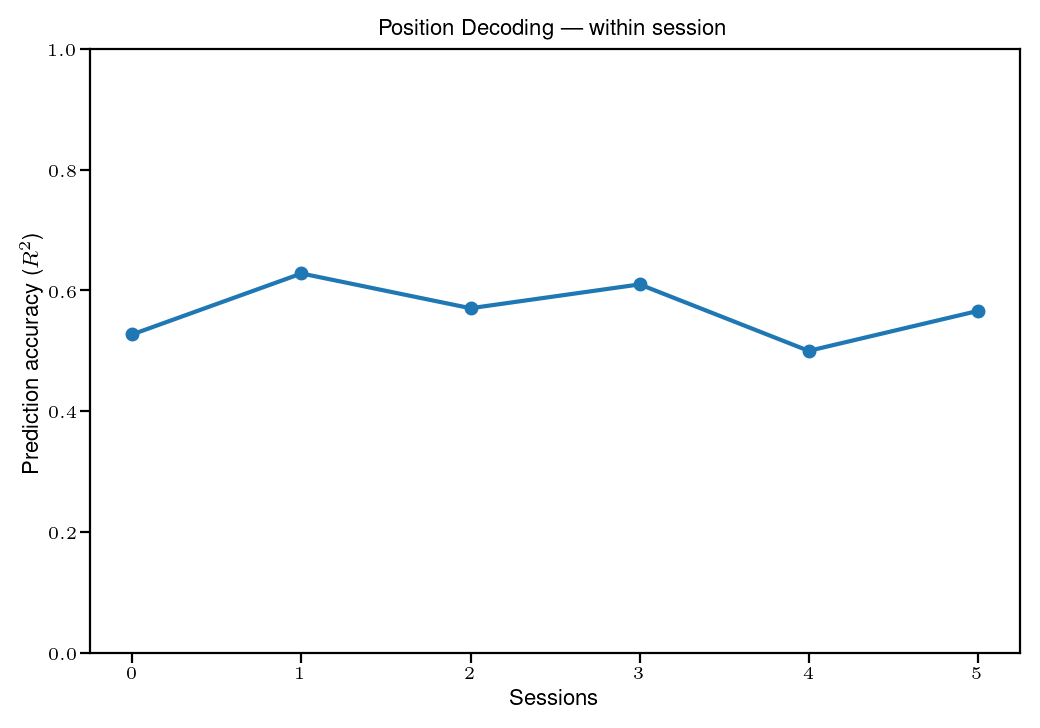

In [4]:
if "__file__" not in dir():
    set_rc()
    _,ax = plt.subplots(dpi=100)
    ax.plot(pop_score_day,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Sessions');
    ax.set_ylabel('Prediction accuracy ($R^2$)');
    ax.set_title('Position Decoding --- within session');

Now... Same as above, for different animals

# Across animal decoding

## With alignment 

In [4]:
pairIndex_across = []
for i, df1 in enumerate(AllDFs):
    animal1 = df1.mouse[0]
    pairIndex_across.append((i,[]))
    for j, df2 in enumerate(AllDFs):
        if j<i: continue
        animal2 = df2.mouse[0]
        if animal1 == animal2: continue
        pairIndex_across[-1][1].append(j)
pairIndex_across = [(i,j) for i,jList in pairIndex_across for j in jList]

In [5]:
warnings.filterwarnings("ignore")
reg_scores_across = []
for id1, testId in pairIndex_across:
    AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch, area=defs.areas[0], n_components=defs.n_components)
    
    # adding history
    AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel2 = AllVel2.reshape((-1,3))
    AllVel1 = AllVel1.reshape((-1,3))
    
    #remove NaNs from the data 
    nanIndex = np.isnan(AllVel1.T).nonzero()[1]
    nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
    goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
    # print(f'timepoints removed = {len(np.unique(nanIndex))/len(X1)*100:2.1f}%')

    # train the decoder
    *_,U,V = dt.canoncorr(X1[goodIndex,:], X2[goodIndex,:], fullReturn=True)
    Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
    reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    reg_z.fit(U, Y_train_z)
    # test the decoder
    Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
    x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
    z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
    reg_scores_across.append((id1,testId,(x_score,y_score,z_score)))
warnings.filterwarnings("default")

pop_score_across = []
for _,_,scores in reg_scores_across:
    pop_score_across.append(np.mean(scores))
pop_score_across = np.array(pop_score_across)

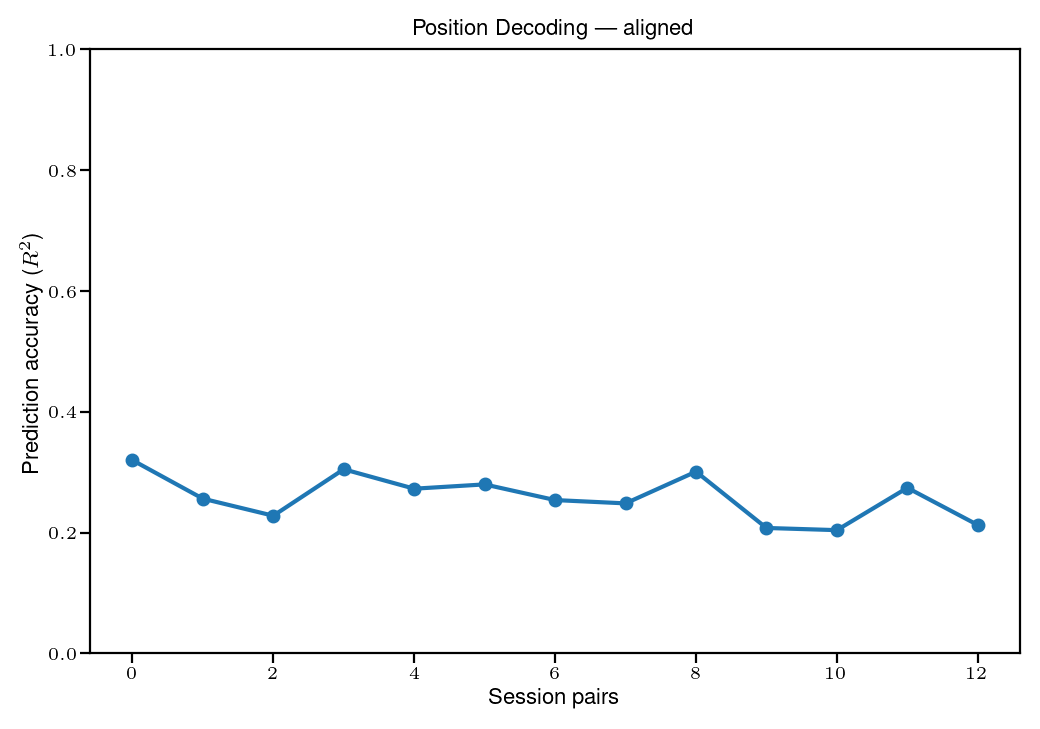

In [7]:
if "__file__" not in dir():

    _,ax = plt.subplots(dpi=100)
    ax.plot(pop_score_across,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs');
    ax.set_ylabel('Prediction accuracy ($R^2$)');
    ax.set_title('Position Decoding --- aligned');

## Without alignment

In [6]:
if "__file__" not in dir():

    warnings.filterwarnings("ignore")
    reg_latent_scores = []
    for id1, testId in pairIndex_across:
        AllData, AllVel = defs.get_data_array_and_vel([AllDFs[id1],AllDFs[testId]], defs.exec_epoch, area=defs.areas[0], n_components=defs.n_components)

        # adding history
        AllData = dt.add_history_to_data_array(AllData,defs.MAX_HISTORY)

        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        _,n_trial,n_time,n_comp = np.min(np.array((AllData1.shape,AllData2.shape)),axis=0)

        X1 = AllData1.reshape((-1,n_comp))
        X2 = AllData2.reshape((-1,n_comp))
        AllVel2 = AllVel2.reshape((-1,3))
        AllVel1 = AllVel1.reshape((-1,3))

        #remove NaNs from the data 
        nanIndex = np.isnan(AllVel1.T).nonzero()[1]
        nanIndex = np.append(nanIndex, np.isnan(AllVel2.T).nonzero()[1])
        goodIndex = np.delete(np.arange(len(X1)), np.unique(nanIndex))
        # print(f'timepoints removed = {len(np.unique(nanIndex))/len(X1)*100:2.1f}%')

        # train the decoder
        U,V = X1[goodIndex,:], X2[goodIndex,:]
        Y_train_x,Y_train_y,Y_train_z = AllVel1.T[:,goodIndex]
        reg_x, reg_y, reg_z = LinearRegression(), LinearRegression(), LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        reg_z.fit(U, Y_train_z)
        # test the decoder
        Y_test_x,Y_test_y,Y_test_z = AllVel2.T[:,goodIndex]
        x_score = defs.custom_r2_func(Y_test_x, reg_x.predict(V))
        y_score = defs.custom_r2_func(Y_test_y, reg_y.predict(V))
        z_score = defs.custom_r2_func(Y_test_z, reg_z.predict(V))
        reg_latent_scores.append((id1,testId,(x_score,y_score,z_score)))
    warnings.filterwarnings("default")

    pop_latent_score = []
    for _,_,scores in reg_latent_scores:
        pop_latent_score.append(np.mean(scores))
    pop_latent_score = np.array(pop_latent_score)

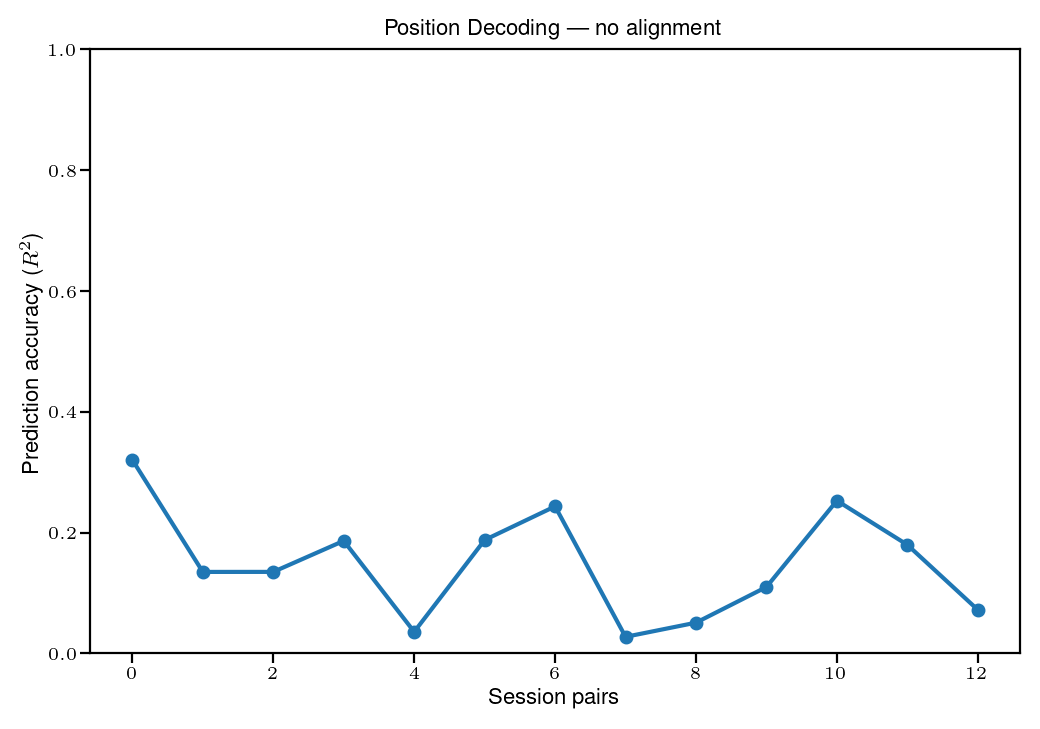

In [9]:
if "__file__" not in dir():

    _,ax = plt.subplots(dpi=100)
    ax.plot(pop_latent_score,'-o')
    ax.set_ylim([0,1])
    ax.set_xlabel('Session pairs');
    ax.set_ylabel('Prediction accuracy ($R^2$)');
    ax.set_title('Position Decoding --- no alignment');

# Universal Decoder

In [10]:
#%run "_M1-universal-decoding.ipynb"

# histograms

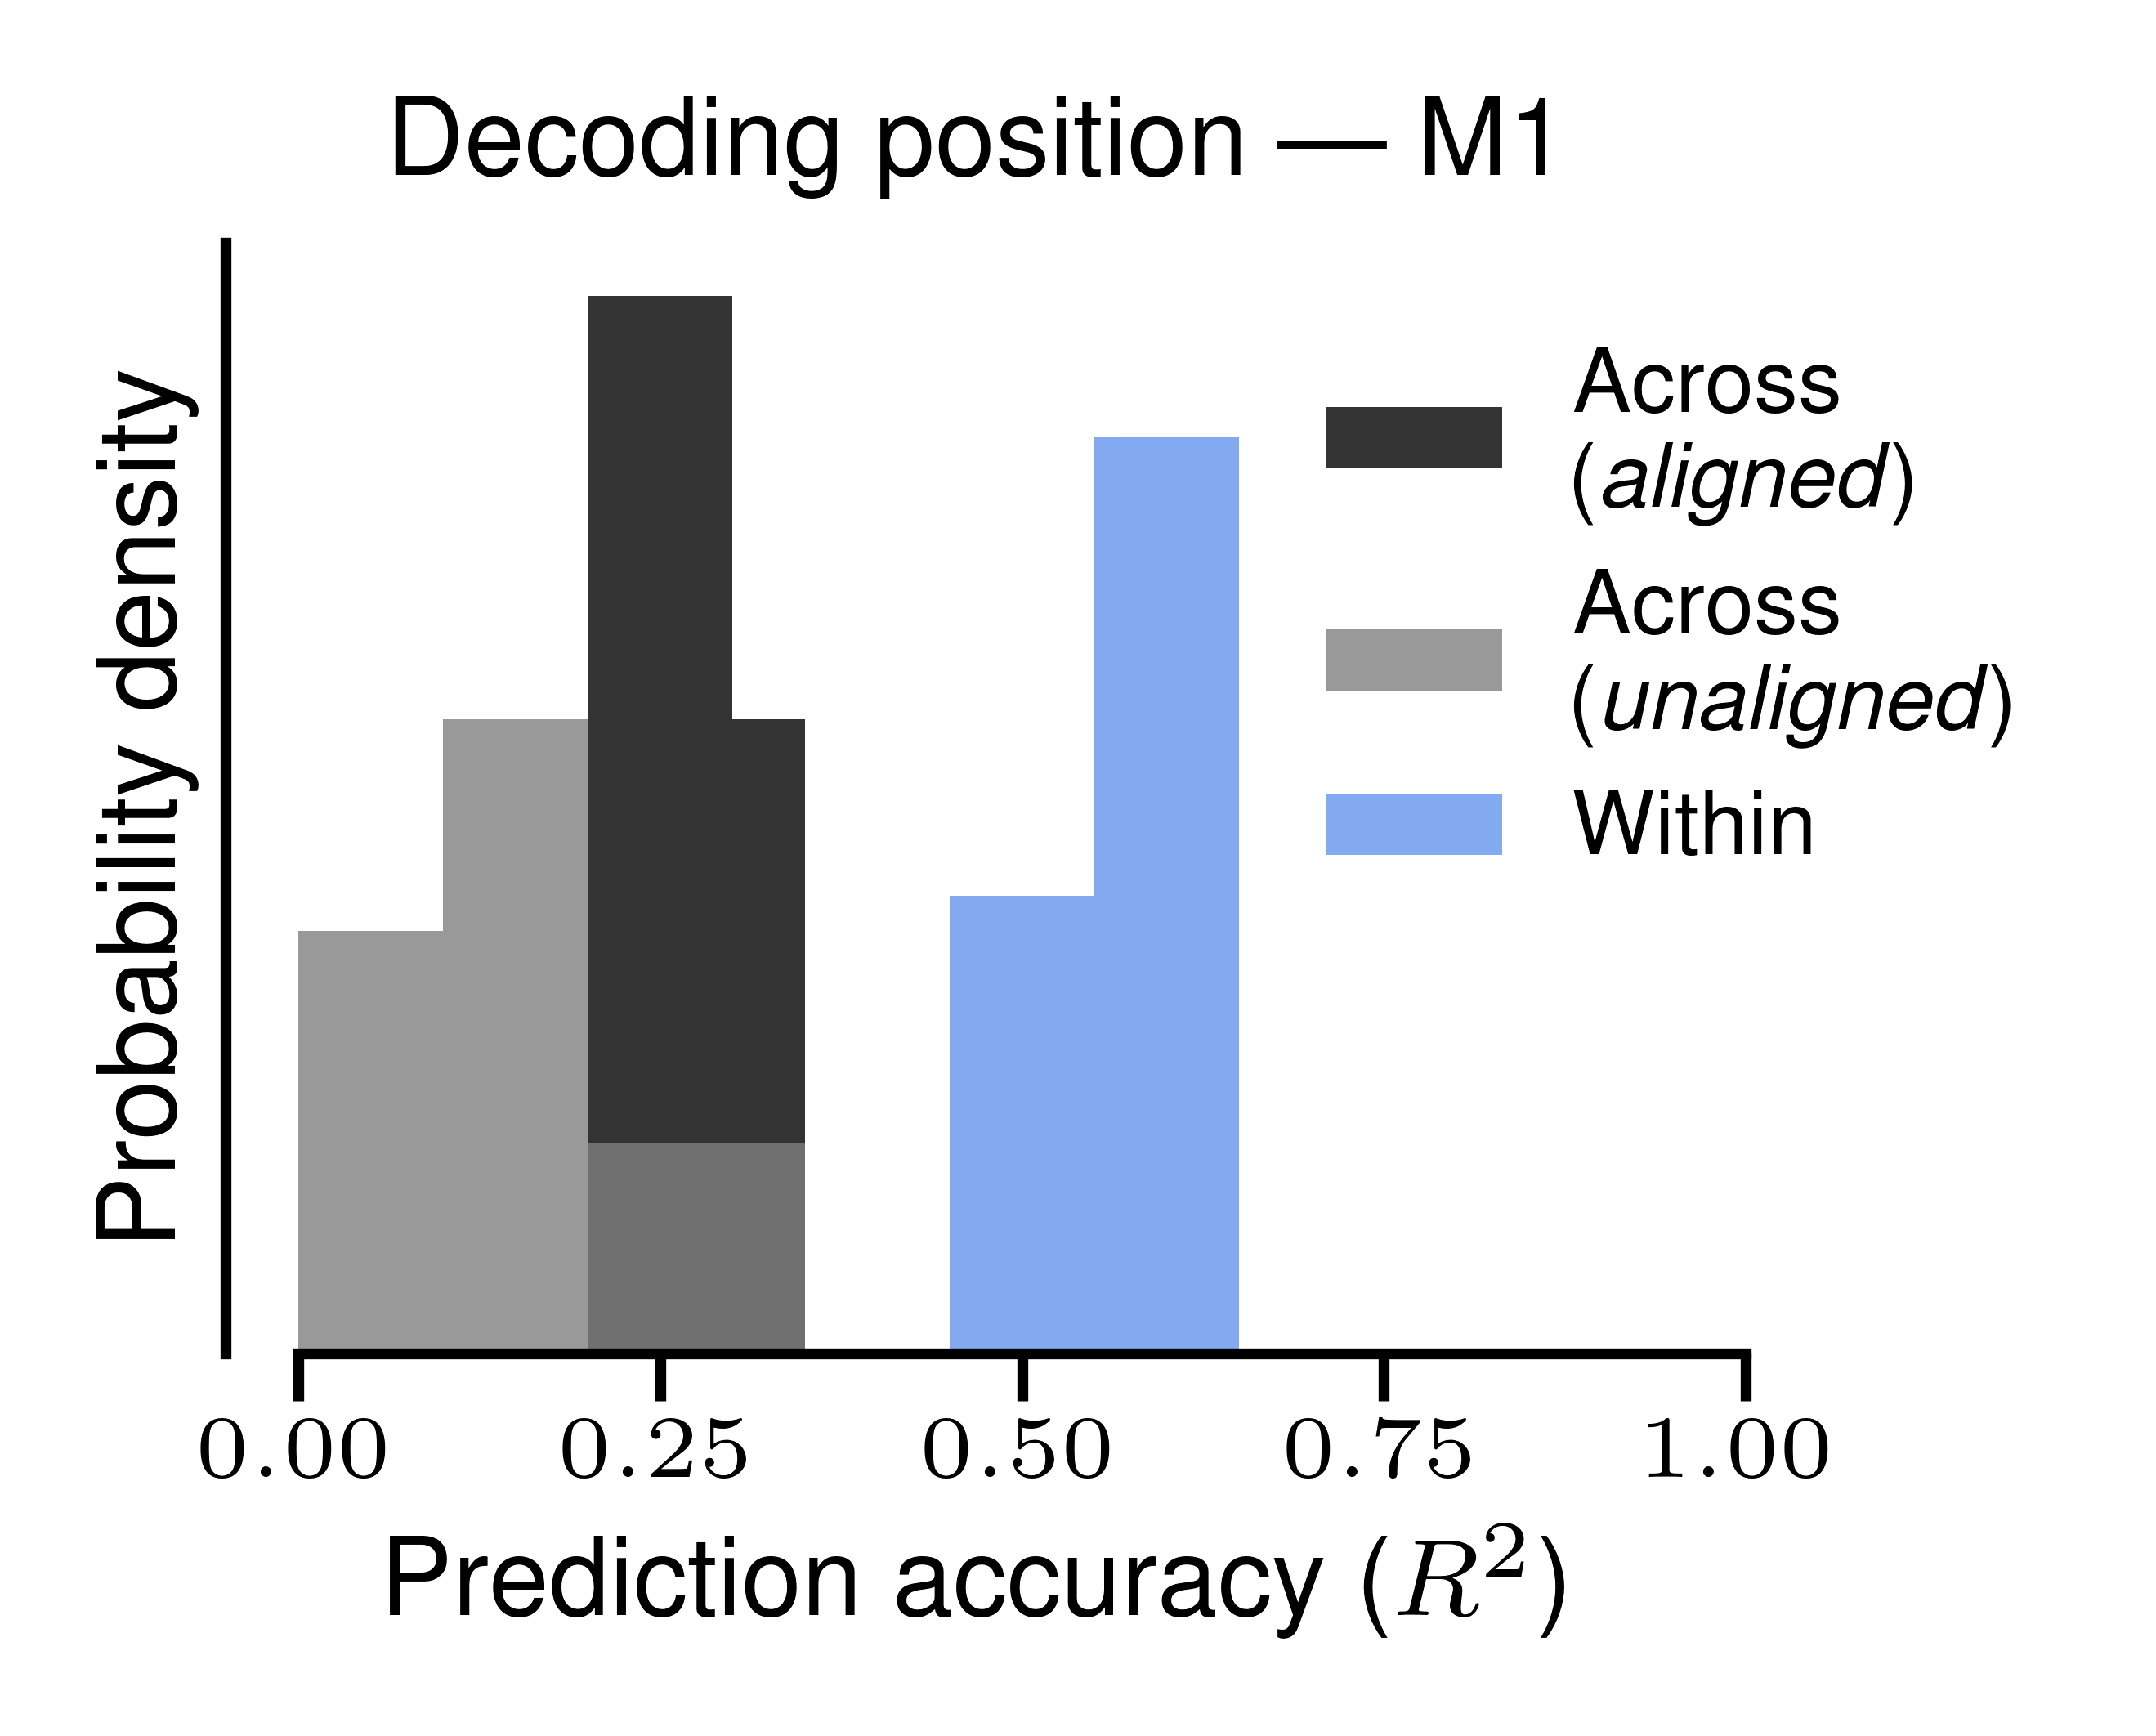

In [14]:
if "__file__" not in dir():

    fig,ax = plt.subplots(figsize=params.panels.decoding_hist)

    bins = np.arange(0,1,0.05)
    ax.hist(pop_score_across, bins=bins, density=True, label='Across\n' r'(\textit{aligned})',
            alpha=.8, color=params.colors.MainCC)
    ax.hist(pop_latent_score, bins=bins, density=True, label='Across\n' r'(\textit{unaligned})',
            alpha=.8, color=params.colors.LowerCC)
    ax.hist(pop_score_day, bins=bins, density=True, label='Within',
            alpha=.8, color=params.colors.UpperCC)
    # ax.hist(pop_score_uni, bins=bins, density=True, label='Universal', alpha=.8)

    ax.set_title('Decoding position --- M1')
    ax.set_xlabel('Prediction accuracy ($R^2$)')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('Probability density')
    ax.set_yticks([])
    ax.set_xlim([-.05,1])
    ax.legend(loc=(.7,.4))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([0,1])

    fig.savefig(params.figPath / 'mouse-M1-decode.pdf', format='pdf', bbox_inches='tight')